the following code is highly inspired from https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

In [4]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [128]:
negative = pd.read_excel(r'.\negative_sentiment.xlsx')
negative['label'] = 0
positive = pd.read_excel(r'.\positive_sentiment.xlsx')
positive['label'] = 1

# Concatenate complaining and non-complaining data
data = pd.concat([negative, positive], axis=0).reset_index(drop=True)

data

,Unnamed: 0,0,label
0,0,yeh mate thats cool the super acid is so nice ...,0
1,1,raw uracilncooked super acid shard so uracil c...,0
2,2,"with all this super acid, we super acid for th...",0
3,3,do you want to articulation for a super acid,0
4,4,you ll be visual_perception angels in no time ...,0
...,...,...,...
19995,9995,Just say no to methamphetamine and yes to life,1
19996,9996,suit up against a new enemy methamphetamine th...,1
19997,9997,So no to methamphetamine because it is killing...,1
19998,9998,when it comes to methamphetamine and alcohol ...,1


In [129]:
from sklearn.model_selection import train_test_split

X_0 = negative[0].values
y_0 = negative['label'].values

X_1 = positive[0].values
y_1 = positive['label'].values

X0_train, X0_val, y0_train, y0_val =\
    train_test_split(X_0, y_0, test_size=0.3, random_state=2020)
X1_train, X1_val, y1_train, y1_val =\
    train_test_split(X_1, y_1, test_size=0.3, random_state=2020)
X_train = np.hstack((X0_train, X1_train))
y_train = np.hstack((y0_train, y1_train))
X_val = np.hstack((X0_val, X1_val))
y_val = np.hstack((y0_val, y1_val))

In [130]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [131]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ddave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [133]:
max_len = max([len(sentence) for sentence in data[0].values])
print('Max length: ', max_len)

Max length:  167


In [134]:
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\ddave\anaconda3\envs\pytorch_\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  yeh mate thats cool the super acid is so nice though mate amnesia heterosexual from the dam
Token IDs:  [101, 6300, 2232, 6775, 2008, 2015, 4658, 3565, 5648, 3835, 2295, 6775, 29222, 28229, 5477, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [135]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [136]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        
        return logits

In [137]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=2):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=1.1e-4,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [138]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()
loss_per_itr=[]
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=2, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                torch.save(model, 'model_updated.pth') #saving model
                loss_per_itr.append(batch_loss / batch_counts)
                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

(Do not run this cell while testing- this is the training function)

In [139]:
import pickle
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\ddave\anaconda3\envs\pytorch_\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and wi

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.623472   |     -      |     -     |  922.71  
   1    |   40    |   0.369023   |     -      |     -     |  943.65  
   1    |   60    |   0.283889   |     -      |     -     |  1052.66 
   1    |   80    |   0.148829   |     -      |     -     |  1093.88 
   1    |   100   |   0.080028   |     -      |     -     |  817.38  
   1    |   120   |   0.060123   |     -      |     -     |  735.31  
   1    |   140   |   0.018878   |     -      |     -     |  730.66  
   1    |   160   |   0.014458   |     -      |     -     |  737.31  
   1    |   180   |   0.037358   |     -      |     -     |  732.45  
   1    |   200   |   0.040755   |     -      |     -     |  736.11  
   1    |   220   |   0.043269   |     -      |     -     |  742.13  
   1    |   240   |   0.056732   |     -      |     -     |  866.74  


In [ ]:
torch.save('./model') #saving model

loading the model:

In [ ]:
model= torch.load('.\model.pth')

In [141]:
import torch.nn.functional as F
def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [142]:
probs = bert_predict(bert_classifier, val_dataloader)

In [143]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
   
    preds = probs[:, 1]
    
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    
# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

Accuracy: 99.95%


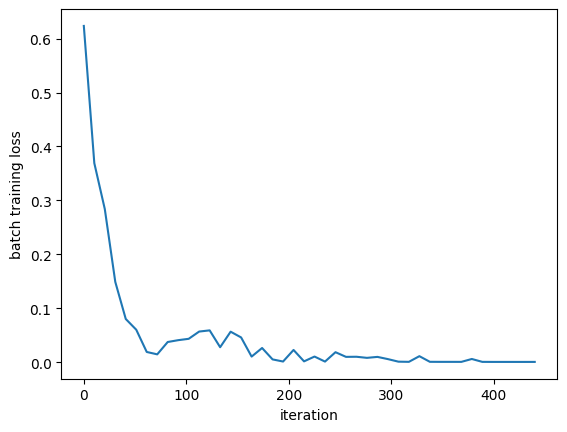

In [162]:
x= np.linspace(0,440,44)
plt.plot(x, loss_per_itr)
plt.xlabel('iteration')
plt.ylabel('batch training loss')
plt.show()

In [166]:
threshold = 0.95
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of sentences predicted positive: ", preds.sum())
output_positive = X_val[preds==1]
output_negative = X_val[preds==0]
print('positive sentences as predicted by model: \n', output_positive[-10:],'\nnegative sentences as predicted by model: \n',output_negative[:10]  )


Number of sentences predicted positive:  3000
positive sentences as predicted by model: 
 ['when it comes to blue kisses and alcohol  just say no'
 'no bomb, no beer, no poppers you smoke it up on your own time'
 'I recently received my Amazon Fire TV after months of researching which streamin'
 'my relation with slick superspeed is in history book now'
 "Stress is dangerous How's the Batata Saung working out"
 'our organization, within six calendar_month,will be out of the happy dust business'
 ' Good Locha for money Call me ' 'coke are not good for health'
 ' The bags of Bajri no rotlo smell potent as i weigh up their value based on the ideals of monetary gain'
 ' So much weight it dragging me down Relieve me of this fragrant Amti bounty Delivery 6pm 1 am '] 
negative sentences as predicted by model: 
 ['been keeping an eye on that blue snow of yours'
 'rolls royce vitamin  d tabs 210 each if you are referred by a vitamin  d'
 'you act like gorillas after arctic blast'
 'snow and Hoo

Optionally, the method showed on the website: https://medium.com/@lorenagongang/sentiment-analysis-on-streaming-twitter-data-using-kafka-spark-structured-streaming-python-part-b27aecca697a could be adopted to create pipelines of data and perform sentiment analyses on streaming data from other APIs. This could be an extension for future work which I beleive would better serve the use case for your business, since you could monitor chats in real time.